This notebook can be used to analyse the Helsinki outdoor gym dataset, which contains data from sensors that records usage of each equipment in the gym.

  - The tasks are solved using Pyspark
  - External Libraries used: unittest, pandas, matplotlib
  - The details of the dataset & Tasks can be found in the repository under /src/docs/
  - This notebook has solutions for the tasks

#Task 1:

In [0]:
# Add imports here.
from pyspark.sql import SparkSession
from pyspark.sql.types import TimestampType, IntegerType
from pyspark.sql.functions import col

In [0]:
# Intiate Spark object.
builder = pyspark.sql.SparkSession.builder.appName("outdoor_gym_analytics")
spark = builder.enableHiveSupport().getOrCreate()

In [0]:
def read_csv_as_df(
        file_path: str,
        column_mapping_path: str,
        timestamp_column: str,
        header: bool = True,
        sep: str = ',',
):
    """
    Reads CSV file and returns Pyspark dataframe.
    """
    df = spark.read.csv(file_path, header = header, sep = sep)
    df = df.withColumn(timestamp_column,df[timestamp_column].cast(TimestampType()))
    _col_mapping_df = spark.read.csv(column_mapping_path, header = header, sep = sep)
    _col_mapping_lst = _col_mapping_df.rdd.map(lambda row: {row['beacon']: row['laitekuvaus']}).collect()
    for column_pair in _col_mapping_lst:
        for old_col, new_col in column_pair.items():
            df = df.withColumn(old_col, df[old_col].cast('int'))
            df = df.withColumnRenamed(old_col, new_col)
    df.show(10, truncate = False)
    return df

In [0]:
df = read_csv_as_df(file_path = '../dataset/hietaniemi_gym_data.csv', timestamp_column = 'time', column_mapping_path = '../dataset/column_mapping.csv')

+-------------------+---------+-----------------+-------------------+-----------+---------------+-------+-----------+----------+
time |etupenkki|ojentajapunnerrus|vinopenkkipunnerrus|hauiskaanto|penkkipunnerrus|yloveto|jalkakyykky|soutulaite|
+-------------------+---------+-----------------+-------------------+-----------+---------------+-------+-----------+----------+
2020-04-24 00:00:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 00:10:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 00:20:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 00:30:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 00:40:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 00:50:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 01:00:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 01:10:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 01:20:00|2 |2 |2 |2 |2 |2 |2 |2 |
2020-04-24 01:30:00|2 |2 |2 |2 |2 |2 |2 |2 |
+-------------------+---------+-----------------+-------------------+-----------+---------------+-------+-----------+----------+
only showing top 10 rows

In [0]:
def agg_hour_gym_device(df, limit_rows):
    from pyspark.sql.functions import hour, to_date
    df.groupBy(to_date('time').alias('date_of_ts'), hour('time'
               ).alias('hour_of_ts')).sum(*df.drop('time'
            ).columns).orderBy(['date_of_ts', 'hour_of_ts'
                               ]).show(limit_rows)
    return df.groupBy(to_date('time').alias('date_of_ts'), hour('time'
                      ).alias('hour_of_ts')).sum(*df.drop('time'
            ).columns).orderBy(['date_of_ts', 'hour_of_ts'])

In [0]:
# Aggregate to hourly precision by summing the usage statistics for each gym device during the hour. Present 10 first rows of the dataset.
agg_hour_gym_device(df=df, limit_rows = 10)

+----------+----------+--------------+----------------------+------------------------+----------------+--------------------+------------+----------------+---------------+
date_of_ts|hour_of_ts|sum(etupenkki)|sum(ojentajapunnerrus)|sum(vinopenkkipunnerrus)|sum(hauiskaanto)|sum(penkkipunnerrus)|sum(yloveto)|sum(jalkakyykky)|sum(soutulaite)|
+----------+----------+--------------+----------------------+------------------------+----------------+--------------------+------------+----------------+---------------+
2020-04-24| 0| 12| 12| 12| 12| 12| 12| 12| 12|
2020-04-24| 1| 12| 12| 12| 12| 12| 12| 12| 12|
2020-04-24| 2| 12| 12| 12| 14| 12| 13| 12| 13|
2020-04-24| 3| 13| 14| 15| 12| 18| 20| 23| 20|
2020-04-24| 4| 24| 15| 23| 24| 19| 25| 30| 28|
2020-04-24| 5| 19| 15| 18| 12| 19| 20| 28| 18|
2020-04-24| 6| 36| 28| 34| 25| 28| 30| 30| 34|
2020-04-24| 7| 28| 26| 24| 22| 26| 31| 26| 26|
2020-04-24| 8| 32| 25| 25| 21| 34| 30| 44| 33|
2020-04-24| 9| 35| 28| 37| 33| 40| 44| 41| 32|
+----------+----------+--------------+----------------------+------------------------+----------------+--------------------+------------+----------------+---------------+
only showing top 10 rows

Out[76]: DataFrame[date_of_ts: date, hour_of_ts: int, sum(etupenkki): bigint, sum(ojentajapunnerrus): bigint, sum(vinopenkkipunnerrus): bigint, sum(hauiskaanto): bigint, sum(penkkipunnerrus): bigint, sum(yloveto): bigint, sum(jalkakyykky): bigint, sum(soutulaite): bigint]

#Task 2

In [0]:
%run "../tests/DQTestCases"

In [0]:
import unittest

class MyNotebookTests(unittest.TestCase):
  
  def test_record_count(self):
    self.assertGreaterEqual(check_record_count(df=df), 50000)
    
  def test_date_range(self):
    self.assertGreaterEqual(check_date_range(df=df, test_col = 'time', start_date = '2020-04-24', end_date = '2021-05-11'),1)
    
  def test_negative_values(self):
    self.assertEqual(check_negative_values(df=df), False)

suite = unittest.TestLoader().loadTestsFromTestCase(MyNotebookTests)
runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

test_date_range (__main__.MyNotebookTests) ... ok
test_negative_values (__main__.MyNotebookTests) ... ok
test_record_count (__main__.MyNotebookTests) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.973s

OK
Out[303]: <unittest.runner.TextTestResult run=3 errors=0 failures=0>

#Task 3

In [0]:
# What was the most popular device during the tracking period measured by number of minutes used?
def get_popular_device(df):
  numeric_cols = [f'sum({f.name}) as {f.name}' for f in df.schema.fields if isinstance(f.dataType, IntegerType)]
  df_aggregated = df.selectExpr(*numeric_cols)
  df_aggregated.show()
  equipment_max_used = df_aggregated.toPandas().idxmax(axis=1)
  print(f'Most Used Equipment is: {equipment_max_used[0]}')
  return equipment_max_used[0]

In [0]:
get_popular_device(df = df)
# Most Used Equipment is: jalkakyykky. Thats used for 182532 minutes.

+---------+-----------------+-------------------+-----------+---------------+-------+-----------+----------+
etupenkki|ojentajapunnerrus|vinopenkkipunnerrus|hauiskaanto|penkkipunnerrus|yloveto|jalkakyykky|soutulaite|
+---------+-----------------+-------------------+-----------+---------------+-------+-----------+----------+
 170715| 162177| 167443| 158436| 173516| 147908| 182532| 147323|
+---------+-----------------+-------------------+-----------+---------------+-------+-----------+----------+

Most Used Equipment is: jalkakyykky
Out[120]: 'jalkakyykky'

In [0]:
# Did time of day (hour) impact overall popularity of the outdoor gym?
from pyspark.sql.functions import hour, to_date, dayofweek
df_agg_by_equipment = df.groupBy(hour("time").alias("hour_of_ts")).sum(*df.drop('time').columns).orderBy(['hour_of_ts'])
df_agg_by_equipment_pdf = df_agg_by_equipment.toPandas()

In [0]:
df_agg_by_equipment_pdf['sum_of_all_devices'] = df_agg_by_equipment_pdf.drop('hour_of_ts', axis=1).sum(axis=1)
df_agg_by_equipment_pdf

,hour_of_ts,sum(etupenkki),sum(ojentajapunnerrus),sum(vinopenkkipunnerrus),sum(hauiskaanto),sum(penkkipunnerrus),sum(yloveto),sum(jalkakyykky),sum(soutulaite),sum_of_all_devices
0,0,4607,4609,4613,4606,4616,4603,4614,4598,36866
1,1,4656,4604,4700,4604,4680,4597,4705,4598,37144
2,2,4706,4658,4712,4627,4817,4641,4757,4637,37555
3,3,4961,4976,5043,4906,5081,4936,5058,4916,39877
4,4,5895,5514,5771,5481,6164,5541,6349,5556,46271
5,5,6368,5972,6106,5884,6417,5839,6960,5847,49393
6,6,6945,6323,6769,6248,6967,6234,7659,6055,53200
7,7,7806,7161,7442,6870,7953,6825,8362,6631,59050
8,8,8769,7791,8286,7861,8697,7118,9256,7018,64796
9,9,9090,8012,8737,8141,9060,7330,9637,7301,67308


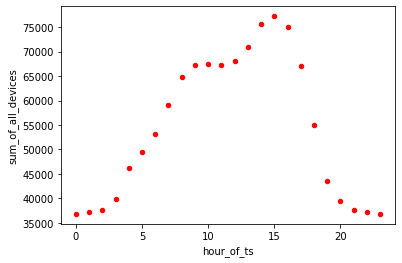

In [0]:
# Did time of day (hour) impact overall popularity of the outdoor gym?
import matplotlib.pyplot as plt

# Scatter plot: hour_of_ts Vs sum_of_all_deivices_each_hour
df_agg_by_equipment_pdf.plot(kind='scatter',x='hour_of_ts',y='sum_of_all_devices',color='red')
plt.show()

# Yes, it can be interpreted from the plot that, between 5-19 is when Gym is more used. Peak usage is reached at 15. Seldom used at midinghts.

In [0]:
# •	Was the gym more popular overall on weekends (Saturday and Sunday) than on weekdays?

from pyspark.sql.functions import hour, to_date, dayofweek
df_agg_by_equipment = df.groupBy(dayofweek("time").alias("day_of_week")).sum(*df.drop('time').columns).orderBy(['day_of_week'])
df_agg_by_equipment_pdf = df_agg_by_equipment.toPandas()


In [0]:
df_agg_by_equipment_pdf['sum_of_all_devices'] = df_agg_by_equipment_pdf.drop('day_of_week', axis=1).sum(axis=1)
df_agg_by_equipment_pdf

,day_of_week,sum(etupenkki),sum(ojentajapunnerrus),sum(vinopenkkipunnerrus),sum(hauiskaanto),sum(penkkipunnerrus),sum(yloveto),sum(jalkakyykky),sum(soutulaite),sum_of_all_devices
0,1,24418,23625,24155,22905,24796,21252,25949,20924,188024
1,2,25404,23750,24848,23098,25956,21488,27377,21636,193557
2,3,24946,23726,24305,23247,25444,21427,26633,21389,191117
3,4,24378,23233,23895,22850,24980,21249,26181,21200,187966
4,5,23866,22645,23499,22333,24385,20891,25727,20982,184328
5,6,24036,22470,23462,22263,24151,21351,25569,21091,184393
6,7,23667,22728,23279,21740,23804,20250,25096,20101,180665


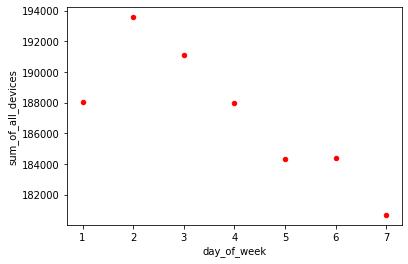

In [0]:
import matplotlib.pyplot as plt

# a scatter plot comparing num_children and num_pets
df_agg_by_equipment_pdf.plot(kind='scatter',x='day_of_week',y='sum_of_all_devices',color='red')
plt.show()

# Was the gym more popular overall on weekends (Saturday and Sunday) than on weekdays?
# 1 - Sunday and 7- Saturday
# Gym is more popular on Weekdays than weekends


#Task 4

•	Weekday as number
•	Hour as number
•	Sum of minutes across all gym devices

In [0]:
col_list = [col for col in df.drop('time').columns]
df_with_new_features = df.withColumn('sum_of_all_gym_equipments',
        expr('+'.join(col_list))).selectExpr(['*',
        'dayofweek(time) as day_of_week', 'hour(time) as hour_of_day',
        'date(time) as date_of_ts']).orderBy('time')
display(df_with_new_features)


time,etupenkki,ojentajapunnerrus,vinopenkkipunnerrus,hauiskaanto,penkkipunnerrus,yloveto,jalkakyykky,soutulaite,sum_of_all_gym_equipments,day_of_week,hour_of_day,date_of_ts
2020-04-24T00:00:00.000+0000,2,2,2,2,2,2,2,2,16,6,0,2020-04-24
2020-04-24T00:10:00.000+0000,2,2,2,2,2,2,2,2,16,6,0,2020-04-24
2020-04-24T00:20:00.000+0000,2,2,2,2,2,2,2,2,16,6,0,2020-04-24
2020-04-24T00:30:00.000+0000,2,2,2,2,2,2,2,2,16,6,0,2020-04-24
2020-04-24T00:40:00.000+0000,2,2,2,2,2,2,2,2,16,6,0,2020-04-24
2020-04-24T00:50:00.000+0000,2,2,2,2,2,2,2,2,16,6,0,2020-04-24
2020-04-24T01:00:00.000+0000,2,2,2,2,2,2,2,2,16,6,1,2020-04-24
2020-04-24T01:10:00.000+0000,2,2,2,2,2,2,2,2,16,6,1,2020-04-24
2020-04-24T01:20:00.000+0000,2,2,2,2,2,2,2,2,16,6,1,2020-04-24
2020-04-24T01:30:00.000+0000,2,2,2,2,2,2,2,2,16,6,1,2020-04-24


#Task 5

In [0]:
from pyspark.sql.functions import split

df_weather = \
    spark.read.csv('../dataset/kaisaniemi_weather_data.csv'
                   , header=True, sep=',')
df_weather = df_weather.withColumn('hour_of_day', split('Hour', ':'
                                   ).getItem(0).cast('int'
                                   )).withColumn('date_of_ts',
        expr('make_date(Year, Month, Day)'))
display(df_weather)


Year,Month,Day,Hour,Timezone,Precipitation (mm),Snow depth (cm),Temperature (degC),hour_of_day,date_of_ts
2020,4,24,00:00,UTC,0,0,6.2,0,2020-04-24
2020,4,24,01:00,UTC,0,0,6.2,1,2020-04-24
2020,4,24,02:00,UTC,0,0,5.1,2,2020-04-24
2020,4,24,03:00,UTC,0,0,4.6,3,2020-04-24
2020,4,24,04:00,UTC,0,0,4.7,4,2020-04-24
2020,4,24,05:00,UTC,0,0,5.1,5,2020-04-24
2020,4,24,06:00,UTC,0,0,5.8,6,2020-04-24
2020,4,24,07:00,UTC,0,0,7.4,7,2020-04-24
2020,4,24,08:00,UTC,0,0,8.8,8,2020-04-24
2020,4,24,09:00,UTC,0,0,9.6,9,2020-04-24


In [0]:
df_weather_gym_merged = df_with_new_features.join(df_weather, on =['hour_of_day', 'date_of_ts'], how = 'inner')
display(df_weather_gym_merged)

hour_of_day,date_of_ts,time,etupenkki,ojentajapunnerrus,vinopenkkipunnerrus,hauiskaanto,penkkipunnerrus,yloveto,jalkakyykky,soutulaite,sum_of_all_gym_equipments,day_of_week,Year,Month,Day,Hour,Timezone,Precipitation (mm),Snow depth (cm),Temperature (degC)
0,2020-04-24,2020-04-24T00:00:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:10:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:20:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:30:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:40:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:50:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:00:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:10:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:20:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:30:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2


In [0]:
# Join gym and weather dataset on hour of each date.
df_weather_gym_merged = df_with_new_features.join(df_weather, on =['hour_of_day', 'date_of_ts'], how = 'inner')
display(df_weather_gym_merged)

hour_of_day,date_of_ts,time,etupenkki,ojentajapunnerrus,vinopenkkipunnerrus,hauiskaanto,penkkipunnerrus,yloveto,jalkakyykky,soutulaite,sum_of_all_gym_equipments,day_of_week,Year,Month,Day,Hour,Timezone,Precipitation (mm),Snow depth (cm),Temperature (degC)
0,2020-04-24,2020-04-24T00:00:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:10:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:20:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:30:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:40:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
0,2020-04-24,2020-04-24T00:50:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,00:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:00:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:10:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:20:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2
1,2020-04-24,2020-04-24T01:30:00.000+0000,2,2,2,2,2,2,2,2,16,6,2020,4,24,01:00,UTC,0,0,6.2


# Bonus Task

In [0]:
from sklearn.externals import joblib

In [0]:
model = joblib.load("/dbfs/FileStore/test/model.pkl")

/databricks/python/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
 UserWarning)

In [0]:
from pyspark.sql.functions import split, dayofweek

df_weather = \
    spark.read.csv('../dataset/kaisaniemi_weather_data.csv'
                   , header=True, sep=',')
df_weather_features = df_weather.withColumn('date_formed',
        expr('make_date(Year, Month, Day)')).withColumn('hour_of_day',
        split('Hour', ':').getItem(0).cast('int'
        )).selectExpr(['cast(dayofweek(date_formed) as int) as Weekday'
                      , 'hour_of_day',
                      'cast(`Precipitation (mm)` as double) as precipitation_in_mm'
                      ,
                      'cast(`Snow depth (cm)` as double) as snow_depth_in_cm'
                      ,
                      'cast(`Temperature (degC)` as double) as temperature_in_cm'
                      ])


In [0]:
display(df_weather_features)

Weekday,hour_of_day,precipitation_in_mm,snow_depth_in_cm,temperature_in_cm
6,0,0.0,0.0,6.2
6,1,0.0,0.0,6.2
6,2,0.0,0.0,5.1
6,3,0.0,0.0,4.6
6,4,0.0,0.0,4.7
6,5,0.0,0.0,5.1
6,6,0.0,0.0,5.8
6,7,0.0,0.0,7.4
6,8,0.0,0.0,8.8
6,9,0.0,0.0,9.6


In [0]:
# Fill missing/NaN values.
df_weather_test = df_weather_features.toPandas().fillna(method='ffill')
df_weather_test['prediction'] = model.predict(df_weather_test)

In [0]:
display(df_weather_test)

Weekday,hour_of_day,precipitation_in_mm,snow_depth_in_cm,temperature_in_cm,prediction
6,0,0.0,0.0,6.2,132.0157721130318
6,1,0.0,0.0,6.2,132.43256400092568
6,2,0.0,0.0,5.1,130.0695337007827
6,3,0.0,0.0,4.6,129.2227700486598
6,4,0.0,0.0,4.7,129.89227304455704
6,5,0.0,0.0,5.1,131.3199093644643
6,6,0.0,0.0,5.8,133.50567900838163
6,7,0.0,0.0,7.4,137.9658486243291
6,8,0.0,0.0,8.8,141.92059602426988
6,9,0.0,0.0,9.6,144.35907677619056
